# Проект e-commerce
#### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.
6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. В кластеризации можешь выбрать следующие метрики: 
 - R - время от последней покупки пользователя до текущей даты,
 - F - суммарное количество покупок у пользователя за всё время,
 - M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.

#### Импортируем необходимые библиотеки для решения поставленных задач

In [149]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.parse import urlencode
import requests
import json
from datetime import timedelta
import calendar
from datetime import timedelta

#### Создаем функцию для считывания данных из яндекс диска

In [4]:
def ydisk(public_key, sep=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if sep: 
        df = pd.read_csv(download_url, sep=';')
    else:
        df = pd.read_csv(download_url)
    return df

#### Выгружаем данные 

In [5]:
olist_customers = 'https://disk.yandex.com.am/d/iHfXl_50C5cHbA'
df_olist_customers = ydisk(olist_customers)
olist_order_items = 'https://disk.yandex.com.am/d/Fj3lZ4hfyzjMzA'
df_olist_order_items = ydisk(olist_order_items)
olist_orders = 'https://disk.yandex.com.am/d/teF5ZRLwHcXIeA'
df_olist_orders = ydisk(olist_orders)

#### Посмотрим на данные 

In [6]:
df_olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
df_olist_customers.shape

(99441, 5)

In [8]:
df_olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
df_olist_order_items.shape

(112650, 7)

In [10]:
df_olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
df_olist_orders.shape

(99441, 8)

#### Преобразуем поля с датами к типу datetime

In [38]:
#df_olist_orders
df_olist_orders['order_purchase_timestamp']      = pd.to_datetime(df_olist_orders.order_purchase_timestamp, dayfirst=True)
df_olist_orders['order_approved_at']             = pd.to_datetime(df_olist_orders.order_approved_at, dayfirst=True)
df_olist_orders['order_delivered_carrier_date']  = pd.to_datetime(df_olist_orders.order_delivered_carrier_date, dayfirst=True)
df_olist_orders['order_delivered_customer_date'] = pd.to_datetime(df_olist_orders.order_delivered_customer_date, dayfirst=True)
df_olist_orders['order_estimated_delivery_date'] = pd.to_datetime(df_olist_orders.order_estimated_delivery_date, dayfirst=True)
#df_olist_order_items
df_olist_order_items['shipping_limit_date'] = pd.to_datetime(df_olist_order_items.shipping_limit_date, dayfirst=True)

#### Для решения задачь ниже данные будут иследоваться следующим образом:
1. За совершенную покупку будет приниматься информация о том,что в столбце order_approved_at в таблице df_olist_orders будет информация что покупатель заплатил за заказ.
2. За дату покупки будет использоваться дата в столбце order_purchase_timestamp таблицы df_olist_orders. Потому что нам неизвестно по какой причине произошла задержка оплаты -- либо сам покупатель решил заплатить позже, либо сама организация долго собирала заказ и высылала счет на оплату (проанализировав данные, есть информация что покупатели платили в тот же день, но есть информация что только через месяц) поэтому за дату покупки будет использоваться информация -- когда человек зашел на сайт и сделал заказ , но при этом он в последсвии заказ оплатил.

#### Вопрос 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Покупкой считается передача или оплата средств за товар.
В таблице df_olist_orders это колонка 'order_approved_at'. 
Если в колонке есть дата подтверждения оплаты, то покупатель совершил покупку.

- Нам необходима информация об уникальном идентификаторе пользователя из таблицы  olist_customers и данные о времени подтверждения оплаты заказа из таблицы olist_orders. 
- Для этого Нам необходимо объеденить таблицы с уникальными id с таблицей с заказами по столбцу customer_id.

In [151]:
df_olist_orders_df_olist_customers = df_olist_customers.merge(df_olist_orders, how='left', on = 'customer_id')

In [152]:
df_olist_orders_df_olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [41]:
df_olist_orders_df_olist_customers.shape

(99441, 12)

Необходимо создать новую колонку order_approved_at_buy, в нее будем добавлять логические значения == есть ли в колонке order_approved_at запись платежа.

In [42]:
df_olist_orders_df_olist_customers['order_approved_at_buy'] = df_olist_orders_df_olist_customers.order_approved_at.notna()

Найдем колличество уникальных пользователей:

In [43]:
df_olist_orders_df_olist_customers.customer_unique_id.nunique()

96096

Находим пользователей с 1 покупкой:
1. Группируем по уникальным пользователям, и суммируем колличество покупок каждого.
2. Отбираем пользователей с 1 покупкой.
3. Считаем колличество пользователей с 1 покупкой.

In [44]:
df_olist_orders_df_olist_customers\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'order_approved_at_buy':'sum'})\
    .query('order_approved_at_buy==1').count()

customer_unique_id       93049
order_approved_at_buy    93049
dtype: int64

Summary == Пользователей совершивших 1 покупку = 93049. 
Всего уникальных пользователей 96096 из них них только меньшая часть повторно совершали покупки.

Вывод: 
- наибольшее колличество клиентов совершают только 1 покупку, на это стоит обрататить внимание и рассмотреть стратегии по их повторном привлечении.

#### Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Заказ не доставлен, не получен клиентом, следовательно в датафрейме df_olist_orders в поле order_delivered_customer_date нет записи, что клиент получил заказ.

In [45]:
df_olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [46]:
df_olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Проверим заказы с просроченной доставкой до клиента - укладываются ли они в отчетный месяц.

In [48]:
df_olist_orders.query('order_estimated_delivery_date<order_delivered_customer_date')\
    .groupby([df_olist_orders['order_estimated_delivery_date'].dt.to_period('M') < df_olist_orders['order_delivered_customer_date'].dt.to_period('M'), 'order_status'])\
    .agg(delivered_in_next_mnth = ('order_id', 'count'))

delivered_in_next_mnth
      order_status                        
False canceled                           1
      delivered                       5846
True  delivered                       1980

Анализ показал, что после опоздания все заказы доставляются.
Просроченных заказов 1980

Проверим есть ли заказы просроченные по причине просрочки передачи заказа в логистику:

In [49]:
df_olist_orders.query('order_estimated_delivery_date < order_delivered_carrier_date').order_id.shape

(473,)

Вывод: 473 заказов просроченны со стороны склада.

Заказы на стадии формирования, обработки и доставки не можем считать "недоставленными". Предположим, что статус "delivered" при отсутвии даты приемки заказа говорит о ситуации - заказ готов к приемке и ждет клиента.

In [50]:
in_process_states = ["created", "invoiced", "approved", "processing", "shipped"]

In [52]:
df_olist_orders.query('order_status not in @in_process_states and order_delivered_customer_date == "NaT" ')\
      .groupby([df_olist_orders['order_estimated_delivery_date'].dt.to_period('M'), 'order_status'])\
      .agg(cnt = ('order_id', 'count'))\
      .groupby(['order_status'])\
      .agg(cnt = ('cnt', 'mean'))\
      .round(0)

,cnt
order_status,
canceled,24.0
delivered,2.0
unavailable,29.0


Ответ: 
- отмененных заказов на разных этапах Жизненного Цикла заказа - 24
- "недоступных" заказа - 29
- доставленных, но ожидается их фактическая приемка (заказчик не пришел за товаром) - 2

#### Вопрос 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Cоздаем датафрейм по полученным заказам ("order_delivered_customer_date != 'NaT' and order_status == 'delivered')

In [58]:
dayWP = df_olist_orders.query("order_status == 'delivered' and order_delivered_customer_date != 'NaT'")\
      .merge(df_olist_order_items, how='inner', on='order_id')

Добавим дни недели и его номер:

In [65]:
dayWP['week_day'] = dayWP.order_purchase_timestamp.dt.day_name()
dayWP['week_day_num'] = dayWP.order_purchase_timestamp.dt.dayofweek

In [66]:
dayWP.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,week_day,week_day_num
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday,2
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday,1


In [62]:
 dayWP.product_id.nunique()

32214

- Группируем по коду товара, номеру и дню недели - здесь опорная дата - это дата формирования заказа (order_purchase_timestamp).
- Считем количество покупок товара, учитывая не только количество заказов, но и количество единиц в рамках заказа (несколько штук товара в одном заказе)
- Сортируем по количеству покупок и номеру дня недели - на случай если за неделю может быть несколько максимумов - будем брать первый максимум
- Берем первые срезы в рамках окна "товар -- день\номер дня недели -- количество" - функция "drop_duplicates"
- Результирующий разпрос:

In [68]:
dayWP.groupby(['product_id', 'week_day', 'week_day_num'], as_index=False)\
        .agg(cnt_of_purchase = ('order_purchase_timestamp', 'count'))\
        .sort_values(['product_id', 'cnt_of_purchase', 'week_day_num'], ascending=[True,False,True])\
        .drop_duplicates(subset = ['product_id'], keep='first')\
        .head()

,product_id,week_day,week_day_num,cnt_of_purchase
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,6,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,3,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,2,1
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1,1


В Таблице представленной выше находится информация по каждому товару - в какой день недели он чаще всего покупается.
Для нахождения конкретного товара можно использовать функцию query 

#### Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Для этого задания используем замержиную таблицу из задания номер 1

In [112]:
df_olist_orders_df_olist_customers.sort_values('order_purchase_timestamp')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at_buy
84697,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,True
70561,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,True
84845,622e13439d6b5a0b486c435618b2679e,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,True
21125,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,True
90294,b106b360fe2ef8849fbbd056f777b4d5,0eb1ee9dba87f5b36b4613a65074337c,2975,sao paulo,SP,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75985,2823ffda607a2316375088e0d00005ec,9bb92bebd4cb7511e1a02d5e50bc4655,7176,guarulhos,SP,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15,False
75902,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23,False
68312,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,registro,SP,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16,False
69139,856336203359aa6a61bf3826f7d84c49,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12,False


За расматриваемый период примем целый месяц. В фрейме данных 'df_olist_orders_df_olist_customers', в столбце 'order_purchase_timestamp' данные начинаются в 04.09.2016 и заканчиваются 17.10.2018, нам не известно с какой даты бралась информация, поэотому для точности анализа отсечем первый и последний месяц в рассматриваемом промежутке.

In [114]:
buy_week = df_olist_orders_df_olist_customers.query("order_purchase_timestamp > '2016-10' and order_purchase_timestamp < '2018-10'")

In [119]:
buy_week.order_purchase_timestamp = pd.to_datetime(buy_week.order_purchase_timestamp).dt.to_period('M').dt.to_timestamp()
# переводим столбец с месяцем к началу месяца для удобства расчетов

In [120]:
buy_week = buy_week.query('order_approved_at_buy ==1')
# оставляем только те строки, где покупатель совершил покупку, а не просто создал заказ.

In [121]:
df_day_is_month = buy_week.groupby(['customer_unique_id','order_purchase_timestamp'], as_index=False).agg({'order_id':'count'})
# группируем сначала по уникальным пользователям  и только потом по дате
# (чтобы в таблице шла информация сначала об пользователе и потом по каким месяцам сколько раз делал покупки), 
# агрегируем колличество.

In [122]:
df_day_is_month['day_is_month'] =  pd.to_datetime(df_day_is_month.order_purchase_timestamp).dt.days_in_month
# создаем колонку day_is_month, где будет иноформация о колличестве дней в месяце

In [123]:
df_day_is_month['is_month'] = (df_day_is_month.day_is_month/7).round(2)
# создаем колонку is_month, где будут данные о колличестве недель в месяце.

In [124]:
df_day_is_month['average_is_month'] = (df_day_is_month.order_id/df_day_is_month.is_month).round(4)
# создаем колонку average_is_month,  где будет информация о среднем значении покупок в неделю в месяц(по месяцам) у каждого пользователя.

In [125]:
df_day_is_month.order_purchase_timestamp = pd.to_datetime(df_day_is_month.order_purchase_timestamp)

In [126]:
df_day_is_month.sort_values(['customer_unique_id','order_purchase_timestamp'])
# сортируем, чтобы сначала шел пользователь в таблице и потом месяцы в которые он делал покупки.
# большинство пользователй совершали покупки только 1 раз,
# соответсвенно только в 1 раз в месяц они делали покупки и среднее в неделю по месяцам выходят в результате такие маленькие

,customer_unique_id,order_purchase_timestamp,order_id,day_is_month,is_month,average_is_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,4.43,0.2257
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,31,4.43,0.2257
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,31,4.43,0.2257
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,31,4.43,0.2257
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,30,4.29,0.2331
...,...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,30,4.29,0.2331
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,31,4.43,0.2257
97909,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,28,4.00,0.2500
97910,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,31,4.43,0.2257


В столбце df_day_is_month.average_is_month находится информация сколько у каждого из пользователей в среднем покупок в неделю (по месяцам).
Для нахождении информации по конкретному пользователю можно в функцию query по столбцу customer_unique_id ввести id пользователя

Проверим на тестовых клиентах

In [131]:
df_day_is_month.query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'")

,customer_unique_id,order_purchase_timestamp,order_id,day_is_month,is_month,average_is_month
53960,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,1,31,4.43,0.2257
53961,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,1,30,4.29,0.2331
53962,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,3,31,4.43,0.6772
53963,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,1,31,4.43,0.2257
53964,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-01,1,30,4.29,0.2331
53965,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-01,2,31,4.43,0.4515
53966,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,1,30,4.29,0.2331
53967,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2,31,4.43,0.4515
53968,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,2,31,4.43,0.4515
53969,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,3,31,4.43,0.6772


#### Вопрос 5. Используя pandas, проведи когортный анализ пользователей.

Здесь примем за дату первой покупки дату приемки первого заказа - order_delivered_customer_date, так мы руководствуемся тем, что клиент принимает решение об удобстве сервиса, пройдя весь сценарий взаимодействия с маркетплейсом - от корзины до получения товара.

Датой "возврата" будет первая дата следующего взаимодействия (формирование корзины нового заказа) - order_purchase_timestamp 

In [132]:
ord_cst_df = pd.merge(df_olist_orders.query("order_delivered_customer_date != 'NaT' and order_status == 'delivered'")[['order_id', 'customer_id', 'order_delivered_customer_date']],
                      df_olist_customers[['customer_unique_id', 'customer_id']], how='inner', on='customer_id')

In [134]:
ord_cst_df.head()

,order_id,customer_id,order_delivered_customer_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-08-07 15:27:45,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-17 18:06:29,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-12-02 00:28:42,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-16 18:17:02,72632f0f9dd73dfee390c9b22eb56dd6


Определим месяц-год первого полученного заказа

In [137]:
ord_cst_df['purchase_month'] = ord_cst_df['order_delivered_customer_date'].dt.strftime('%Y-%m')
ord_cst_df.head()

,order_id,customer_id,order_delivered_customer_date,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-08-07 15:27:45,af07308b275d755c9edb36a90c618231,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-17 18:06:29,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-12-02 00:28:42,7c142cf63193a1473d2e66489a9ae977,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-16 18:17:02,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


Расчитаем количество заказов по месяцам

In [139]:
ord_cst_df_cnt = ord_cst_df \
                .groupby('purchase_month', as_index=False) \
                .agg(cnt_by_month = ('order_id', 'count')) \
                .sort_values('purchase_month')
ord_cst_df_cnt.head()

,purchase_month,cnt_by_month
0,2016-10,205
1,2016-11,58
2,2016-12,4
3,2017-01,283
4,2017-02,1351


В период с января по декабрь входит весь 2017 год + январь-март 2018 для retention 12-2017

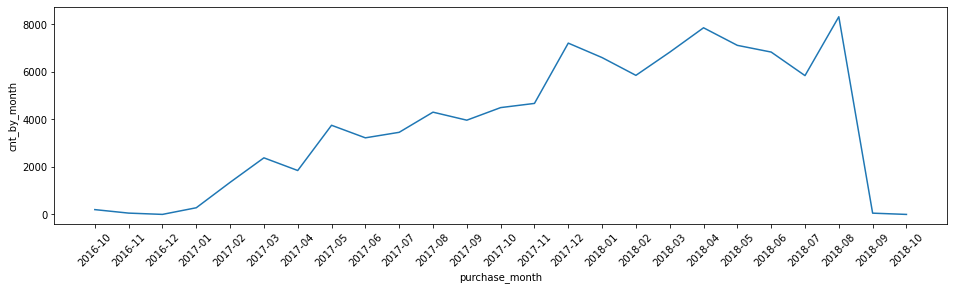

In [141]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=45)
sns.lineplot(x='purchase_month', y ='cnt_by_month', data=ord_cst_df_cnt)

Фильтр покупок с 1 января 2017 по 31 марта 2017

In [142]:
ord_cst_df = ord_cst_df.query('purchase_month >= "2017-01" and purchase_month < "2018-04"')

Разбиение клиентов по когортам, первые покупки до 1 января 2018

In [143]:
cohorts = \
ord_cst_df.query('purchase_month < "2018-01"') \
          .groupby('customer_unique_id', as_index=False) \
          .agg(cohort = ('purchase_month', 'min'))

cohorts.head()

,customer_unique_id,cohort
0,0000f46a3911fa3c0805444483337064,2017-04
1,0000f6ccb0745a6a4b88665a16c9f078,2017-11
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-08


Расчет общего числа клиентов в когорте

In [144]:
cohorts['total_customers']=cohorts.groupby('cohort')['customer_unique_id'].transform('nunique')
cohorts.sort_values('cohort').head()

,customer_unique_id,cohort,total_customers
11993,4d16bcc453234aa62a86defb6b08ab85,2017-01,264
36795,ed05a1bbf9f8816af23fcc68084bb87d,2017-01,264
17739,72025949535cc5d91386aabc4fa7ad86,2017-01,264
15165,611110d26326c28456ebe437516be00e,2017-01,264
321,02251550f4d16aca44ce66e4263c0522,2017-01,264


Назначение месяца покупки клиенту

In [145]:
purchases = ord_cst_df \
    .query('purchase_month >= "2017-01" and purchase_month < "2018-04"') \
    .assign(purchase_month = ord_cst_df['order_delivered_customer_date'].dt.strftime('%Y-%m')) \
    [['purchase_month', 'customer_unique_id']]

Расчет retention

In [146]:
retention_df = \
    pd.merge(purchases, cohorts, on='customer_unique_id', how='inner') \
      .groupby(['cohort', 'purchase_month', 'total_customers'], as_index=False) \
      .agg(num_of_customers = ('customer_unique_id', 'nunique')) \
      .sort_values(['cohort', 'purchase_month'])

retention_df['retention_rate'] = retention_df.num_of_customers.div(retention_df.total_customers).mul(100).round(2)


retention_df.head()

,cohort,purchase_month,total_customers,num_of_customers,retention_rate
0,2017-01,2017-01,264,264,100.00
1,2017-01,2017-02,264,3,1.14
2,2017-01,2017-03,264,1,0.38
3,2017-01,2017-05,264,1,0.38
4,2017-01,2017-06,264,1,0.38


Сводная таблица

In [147]:
retention_df.pivot_table(index='cohort', columns='purchase_month', values='retention_rate', fill_value= 0)

purchase_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
cohort,,,,,,,,,,,,,,,
2017-01,100,1.14,0.38,0.00,0.38,0.38,0.38,0.38,0.00,0.00,0.38,0.76,1.14,0.00,0.38
2017-02,0,100.00,0.68,0.23,0.30,0.30,0.15,0.15,0.23,0.08,0.08,0.15,0.38,0.23,0.15
2017-03,0,0.00,100.00,0.55,0.30,0.43,0.30,0.09,0.30,0.26,0.30,0.21,0.26,0.04,0.04
2017-04,0,0.00,0.00,100.00,0.78,0.28,0.22,0.28,0.17,0.28,0.06,0.39,0.22,0.28,0.11
2017-05,0,0.00,0.00,0.00,100.00,0.74,0.33,0.16,0.35,0.38,0.25,0.35,0.22,0.22,0.25
2017-06,0,0.00,0.00,0.00,0.00,100.00,0.70,0.58,0.45,0.35,0.26,0.38,0.19,0.19,0.22
2017-07,0,0.00,0.00,0.00,0.00,0.00,100.00,0.66,0.18,0.42,0.27,0.27,0.39,0.27,0.21
2017-08,0,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.67,0.48,0.19,0.31,0.53,0.24,0.24
2017-09,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,1.07,0.29,0.42,0.42,0.29,0.23


Наибольший retention на 3-й месяц когорта 2017-06 retention = 0.45

#### Вопрос 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

1. Создаю фрейм данных с данными о продажах(объединяю все 3 таблицы)
2. Оставляем в таблице только тех кто совершил покупку товара. Статус покупки "доставлен", заказ получен клиентом.
3. Оставляем только необходимые столбцы: уникальный айди пользователя, идентификатор товара внутри чека чтобы посчитать общую цену, цену за еденицу товара, время заказа, номер чека.
4. У нас есть данные о продажах примерно за 2 года -- с сентября 2016 по сентябрь 2018. Так как обычно для анализа  RFM используют промежуток равный 1 году, то за период иследования оставим промежуток равный 1 году(365дней),в данном случае период с 2017 года по 2018год так как он наиболее свежий, и больше интересует нас. 


In [192]:
sales = pd.merge(df_olist_orders, df_olist_customers, how='inner', on='customer_id')\
    .query("order_status == 'delivered' and order_delivered_customer_date != 'NaT' and (order_purchase_timestamp >= '2017-01-01' and order_purchase_timestamp < '2018-01-01')")\
    [['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [193]:
sales[sales.duplicated(subset = ['order_id'])]

,customer_unique_id,order_id,order_purchase_timestamp


In [194]:
sales.shape

(43426, 3)

Расчитаем суммарную стоимость заказа - для этого достаточно сгруппировать их по order_id и сложить price.

In [195]:
price =df_olist_order_items.groupby(['order_id'], as_index=False) \
          .agg(ord_price = ('price', 'sum'))

In [196]:
price[price.duplicated(subset = ['order_id'])]

,order_id,ord_price


In [197]:
price.shape

(98666, 2)

In [198]:
sales_df =pd.merge(sales, price, how='inner', on='order_id')

In [199]:
sales_df[sales_df.duplicated(subset = ['order_id'])]

,customer_unique_id,order_id,order_purchase_timestamp,ord_price


In [200]:
sales_df.shape

(43426, 4)

In [201]:
sales_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,ord_price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
2,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,147.90
3,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,59.99
4,39382392765b6dc74812866ee5ee92a7,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,19.90


Наконец, я собираюсь смоделировать анализ, который я провожу в режиме реального времени, 
установив NOW дату на один день после последней покупки. 
Эта дата будет использоваться в качестве ссылки для расчета Recency баллов.

In [208]:
NOW = sales_df['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-01-01 23:29:31')

Я собираюсь изучить данные за период в один год. 
Я установил period переменной значение 365 (дней).
Обычно при сегментации RFM используется значение в один год.

In [209]:
period = 365

Рассчитаем Recency, Frequency и Monetary стоимость каждого клиента

Чтобы упростить задачу,
я собираюсь добавить столбец с количеством дней между покупкой и текущим моментом. 
Чтобы найти значения Recency, мне просто нужно будет найти минимум этого столбца для каждого клиента.

In [240]:
sales_df['DaysSinceOrder'] = sales_df['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

In [241]:
sales_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,ord_price,DaysSinceOrder
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,91
1,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00,44
2,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,147.90,176
3,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,59.99,230
4,39382392765b6dc74812866ee5ee92a7,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,19.90,343


Оценки рассчитываются для каждого клиента. 
Мне нужен фрейм данных с одной строкой для каждого клиента. 
Оценки будут храниться в столбцах.

In [250]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # колличество дней с момента последнего заказа (Recency)
    'order_purchase_timestamp': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # общее количество заказов за последний период (Frequency)
}
rfm = sales_df.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000f46a3911fa3c0805444483337064,297,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1
2,0004aac84e0df4da2b147fca70cf8255,48,1
3,0005e1862207bf6ccc02e4228effd9a0,302,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1


У меня есть данные о недавности и частоте. 
Мне нужно добавить денежную стоимость каждого клиента, добавив продажи за последний год.

In [251]:
df_total_price = sales_df.groupby('customer_unique_id', as_index=False)\
    .agg(Monetary = ('ord_price','sum'))

In [252]:
rfm = rfm.merge(df_total_price, how='left', on = 'customer_unique_id')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90


In [253]:
sales_df.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,order_id,order_purchase_timestamp,ord_price,DaysSinceOrder
2240,8d50f5eadf50201ccdcedfb9e2ac8455,e3071b7624445af6e4f3a1b23718667d,2017-09-05 22:14:52,39.90,118
8375,8d50f5eadf50201ccdcedfb9e2ac8455,bf92c69b7cc70f7fc2c37de43e366173,2017-07-24 22:11:50,149.90,161
14735,8d50f5eadf50201ccdcedfb9e2ac8455,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,13.99,167
17238,8d50f5eadf50201ccdcedfb9e2ac8455,b850a16d8faf65a74c51287ef34379ce,2017-11-22 20:01:53,13.99,40
25577,8d50f5eadf50201ccdcedfb9e2ac8455,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,69.90,149
33749,8d50f5eadf50201ccdcedfb9e2ac8455,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,39.90,197
37125,8d50f5eadf50201ccdcedfb9e2ac8455,89d9b111d2b990deb5f5f9769f92800b,2017-10-29 16:58:02,13.99,64
42464,8d50f5eadf50201ccdcedfb9e2ac8455,cd4b336a02aacabd0ef22f6db711f95e,2017-10-18 23:25:04,29.99,75


In [254]:
rfm.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,Recency,Frequency,Monetary
23193,8d50f5eadf50201ccdcedfb9e2ac8455,40,8,371.56


На данный момент у меня есть значения для параметров Recency, Frequency и Monetary. 
Каждый клиент получит примечание от 1 до 5 для каждого параметра.

Я собираюсь использовать метод квинтилей. Сначала я получаю квинтили для каждого параметра.

In [255]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 38.0, 0.4: 92.0, 0.6: 156.0, 0.8: 231.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 68.8, 0.6: 107.9, 0.8: 179.9}}

Так как мы выяснили , что большинство покупателей покупают только  1 раз,
То метод квантилей не очень подходит для анализа колличества покупок,
Так как во всех квантилях будут значения 1, поэтому к ключам квантилей изменю значения на 1,3,5,7

In [257]:
quintiles['Frequency'][0.4] = 3
quintiles['Frequency'][0.6] = 5
quintiles['Frequency'][0.8] = 7
quintiles

{'Recency': {0.2: 38.0, 0.4: 92.0, 0.6: 156.0, 0.8: 231.0},
 'Frequency': {0.2: 1.0, 0.4: 3, 0.6: 5, 0.8: 7},
 'Monetary': {0.2: 39.9, 0.4: 68.8, 0.6: 107.9, 0.8: 179.9}}

Затем я пишу методы для присвоения рангов от 1 до 5.
Меньшее значение новизны лучше, тогда как более высокая частота и денежные значения лучше.
Мне нужно написать два отдельных метода.

In [258]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

Теперь я готов получить оценки R, F и M каждого клиента.

In [259]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

Наконец, я объединяю оценки R, F и M в RFM Score.

In [260]:
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,3,113
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,4,1,1,411
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,4,1,5,415
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,4,114
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211


Описание сегмента:

In [273]:
# первая версия карты оценок
a_segment_map = {
r'[4-5][4-5][4-5]': 'Лидеры',
r'[2-5][3-5][1-5]': 'Постоянные клиенты',
r'[3-5][1-3][1-5]': 'Потенциально-лояльные',
r'[4-5][1-2][1-2]': 'Недавние',
r'[3-4][1-2][1-2]': 'Перспективные',
    
r'[2-3][2-3][2-3]': 'Требуют внимания',
r'[2-3][1-2][1-2]': 'Собираются уснуть',
r'[1-3][1-5][1-5]': 'Клиенты под угрозой',
r'[1-1][4-5][4-5]': 'Нельзя потерять',
r'[1-2][1-2][1-2]': 'Спящие'
}
# вторая версия карты оценок

segment_map = {
r'[1-2][1-2][1-3]': 'Спящие',
r'[1-2][1-2][3-5]': 'Нельзя упускать',
r'[1-2][3-5][1-3]': 'Засыпают',
r'[1-2][3-5][4-5]': 'Разочарован',
    
r'[3-3][1-2][1-5]': 'Требуют внимания',
r'[3-3][3-5][1-5]': 'Лояльные',
    
r'[4-5][1-2][1-2]': 'Недавние',
r'[4-5][1-4][3-5]': 'Потенциально лидеры',
r'[4-5][4-5][1-3]': 'Постоянные',
r'[4-5][4-5][4-5]': 'Лидеры'
}  
    
rfm['Segment'] = rfm['RFM_Score'].replace(segment_map, regex=True)
#rfm_segment.head()

# запрос для проверки покрытия всех клиентов
rfm.query('Segment not in ("Лидеры","Постоянные клиенты","Потенциально-лояльные","Недавние","Перспективные","Требуют внимания","Собираются уснуть","Клиенты под угрозой","Нельзя потерять","Спящие", \
                  "Спящие","Нельзя упускать","Засыпают","Разочарован","Требуют внимания","Лояльные","Недавние","Потенциально лидеры","Постоянные","Лидеры")') \
           .sort_values("RFM_Score", ascending=True).head(2)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment


In [274]:
rfm_stat = rfm.groupby('Segment', as_index=False) \
                      .agg(clients_num=('customer_unique_id', 'count')) \
                      .sort_values('clients_num', ascending=False)

In [275]:
rfm_stat

,Segment,clients_num
5,Потенциально лидеры,10363
7,Спящие,10193
8,Требуют внимания,8408
3,Недавние,6597
4,Нельзя упускать,6565
0,Засыпают,3
2,Лояльные,2
6,Разочарован,2
1,Лидеры,1


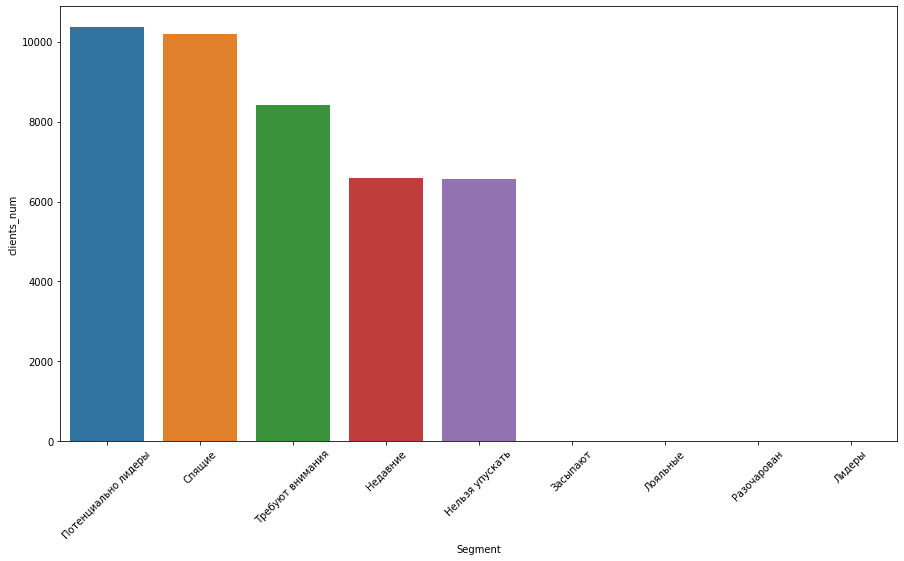

In [276]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
sns.barplot(x='Segment', y='clients_num', data = rfm_stat)

Таким образом, RFM анализ является оптимальным способом для наглядной сегментации пользователей. Так в данных аномально много "потенциальных лидеров", при этом самих "лидеров" очень мало, необходимо это учесть и конвертировать "потенциальных лидеров" при помощи различных бонусов  в "лидеров". 

Очень мало лояльных покупателей, для повышения лояльности необходимо обратить внимание сегментов "спящие", "требуют внимания", "недавние", "нельзя упускать". Напомнить об акции на повторые покупи, привлечь рассылкой и тп.